# MRI reconstruction from multicoil data

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os
import sigpy.mri as mr

import sigpy as sp
import sigpy.mri as mr
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *

from PIL import Image
import PIL
import h5py
from skimage.metrics import structural_similarity as ssim
import pickle
from common.subsample import MaskFunc

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
#from models import *
#from utils.denoising_utils import *

# from facebook MRI
#import transforms
from include import transforms as transform

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    #os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.cuda.set_device(0)
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 3


# Loading MRI measurement

In [2]:
### Get image from the validation set
filename = '/hdd/multicoil_val/file1000190.h5' # good (scale: 3.2) 140 channels

f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']
print("Kspace shape (number slices, number coils, x, y): ", f['kspace'].shape)

# which slice to consider in the following
slicenu = f["kspace"].shape[0]//2

slice_ksp = f['kspace'][slicenu]

slice_ksp_torchtensor = transform.to_tensor(slice_ksp)      # Convert from numpy array to pytorch tensor
slice_image = transform.ifft2(slice_ksp_torchtensor)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = transform.complex_abs(slice_image)   # Compute absolute value to get a real image

Kspace shape (number slices, number coils, x, y):  (36, 15, 640, 368)


In [3]:
numit = 25000
LR = 0.005

In [4]:
output_depth = slice_ksp.shape[0]*2
out_size = slice_ksp.shape[1:]

num_channels = 256
num_layers = 7
strides = [1]*(num_layers-1)
pads = [1]*(num_layers-1)
in_size = [10,5]

parnet = convdecoder(out_size,in_size,output_depth,
                           num_layers,strides,pads,num_channels,skips=False,need_sigmoid=False,bias=True,upsample_mode="nearest").type(dtype)
print(num_param(parnet))
parnet

[(20, 11), (40, 21), (80, 43), (160, 88), (320, 180), (640, 368)]
3952670


conv_model(
  (act_fun): ReLU()
  (net1): Sequential(
    (1): Upsample(size=(20, 11), mode=nearest)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Upsample(size=(40, 21), mode=nearest)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [5]:
scaling_factor = get_scale_factor(parnet,
                                   num_channels,
                                   in_size,
                                   slice_ksp,)

In [6]:
scaling_factor

18544.8553506366

In [7]:
slice_ksp_torchtensor = slice_ksp_torchtensor * scaling_factor
slice_ksp = slice_ksp * scaling_factor

In [8]:
try: # if the file already has a mask
    temp = np.array([1 if e else 0 for e in f["mask"]])
    temp = temp[np.newaxis].T
    temp = np.array([[temp]])
    mask = transform.to_tensor(temp).type(dtype).detach().cpu()
except: # if we need to create a mask
    desired_factor = 12
    undersampling_factor = 0
    tolerance = 0.3
    while undersampling_factor < desired_factor - tolerance or undersampling_factor > desired_factor + tolerance:
        mask_func = MaskFunc(center_fractions=[0.07], accelerations=[desired_factor])  # Create the mask function object
        masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask_func=mask_func)   # Apply the mask to k-space
        mask1d = var_to_np(mask)[0,:,0]
        undersampling_factor = len(mask1d) / sum(mask1d)

mask1d = var_to_np(mask)[0,:,0]

# The provided mask and data have last dim of 368, but the actual data is smaller.
# To prevent forcing the network to learn outside the data region, we force the mask to 0 there.
mask1d[:mask1d.shape[-1]//2-160] = 0 
mask1d[mask1d.shape[-1]//2+160:] =0
mask2d = np.repeat(mask1d[None,:], slice_ksp.shape[1], axis=0).astype(int) # Turning 1D Mask into 2D that matches data dimensions
mask2d = np.pad(mask2d,((0,),((slice_ksp.shape[-1]-mask2d.shape[-1])//2,)),mode='constant') # Zero padding to make sure dimensions match up
mask = transform.to_tensor( np.array( [[mask2d[0][np.newaxis].T]] ) ).type(dtype).detach().cpu()

In [9]:
print(len(mask1d)/sum(mask1d))

11.870967741935484


In [10]:
masked_kspace, mask = transform.apply_mask(slice_ksp_torchtensor, mask = mask)
unders_measurement = np_to_var( masked_kspace.data.cpu().numpy() ).type(dtype)
sampled_image = transform.ifft2(masked_kspace)

## Least-squares estimate from full kspace measurement

The least-squares estimate is obtained from the full kspace measurement by first computing the least estimate for each coil slice and then computing an estimate of the final image via the root sum of squares algorithm:
$$
x_{result} = \sqrt{\sum_{i=1}^n x_i }.
$$
Here, $x_i$ is the $i$-th entry of the image.

In [11]:
# kspace is (numslices, x, y) dimensional and complex-valued
# need (1,numslices,x,y) as output of decoder
# forward model
#    input: (1,numslices,x,y), complex-valued
#    output: (1,numslices,x,y,2), real-valued, where the 2 at the end corresponds to real and complex parts

# generate measurement
def ksp2measurement(ksp):
    return np_to_var( np.transpose( np.array([np.real(ksp),np.imag(ksp)]) , (1, 2, 3, 0)) )

measurement = ksp2measurement(slice_ksp).type(dtype)

In [12]:
# reconstruct from full kspace measurement with build-in function
slice_image_rss = transform.root_sum_of_squares(slice_image_abs, dim=0)

In [13]:
# reconstruct from full kspace measurement by hand
def lsreconstruction(measurement,mode='both'):
    # measurement has dimension (1, num_slices, x, y, 2)
    fimg = transform.ifft2(measurement)
    normimag = torch.norm(fimg[:,:,:,:,0])
    normreal = torch.norm(fimg[:,:,:,:,1])
    print("real/img parts: ",normimag, normreal)
    if mode == 'both':
        return torch.sqrt(fimg[:,:,:,:,0]**2 + fimg[:,:,:,:,1]**2)
    elif mode == 'real':
        return torch.tensor(fimg[:,:,:,:,0]) #torch.sqrt(fimg[:,:,:,:,0]**2)
    elif mode == 'imag':
        return torch.sqrt(fimg[:,:,:,:,1]**2)

In [14]:
def root_sum_of_squares(lsimg):
    out = np.zeros(lsimg[0].shape)
    for img in lsimg:
        out += img**2
    return np.sqrt(out)

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

real/img parts:  tensor(719.4630, device='cuda:0') tensor(644.8469, device='cuda:0')


(-0.5, 319.5, 319.5, -0.5)

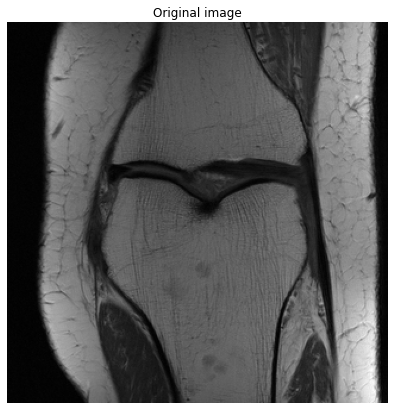

In [15]:
lsimg = lsreconstruction(measurement)
lsrec = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(121)
ax1.imshow(lsrec,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

In [16]:
def channels2imgs(out):
    sh = out.shape
    chs = int(sh[0]/2)
    imgs = np.zeros( (chs,sh[1],sh[2]) )
    for i in range(chs):
        imgs[i] = np.sqrt( out[2*i]**2 + out[2*i+1]**2 )
    return imgs

In [17]:
# the forward model - treats real and complex part of each slice as a separate channel
def forwardm(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = transform.fft2(fimg) # dim: (1,num_slices,x,y,2)
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

### Deep decoder setup

In [18]:
num_param(parnet)

3952670

In [19]:
out = []
for img in sampled_image:
    out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]
lsest = torch.tensor(np.array([out]))

In [20]:
sover,pover,par_mse_n, par_mse_t, parni, parnet = fit( in_size = in_size,
                                                num_channels=[num_channels]*(num_layers-1),
                                                #reg_noise_decayevery = rnd,
                                                #reg_noise_std=rn,
                                                num_iter=numit,
                                                LR=LR,
                                                mask = mask2d,
                                                apply_f = forwardm,
                                                img_noisy_var=unders_measurement,
                                                net=parnet,
                                                upsample_mode="free",
                                                img_clean_var=Variable(lsest).type(dtype),
                                                lsimg = lsimg,
                                                find_best=True,)

input shape:  [1, 256, 10, 5]
optimize with adam 0.005


## Downsampling factor = 12
num_channels: 256 <br>
insize: [10,5] <br> 
num_layers: 7 <br>
iter=25000, lr=0.005

In [21]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

ssim_const = ssim(orig, prec,data_range=orig.max())

psnr_const = psnr(orig,prec,np.max(orig))

real/img parts:  tensor(719.4630, device='cuda:0') tensor(644.8469, device='cuda:0')


In [22]:
psnr_const,ssim_const

(26.63542555203171, 0.6771600617315635)

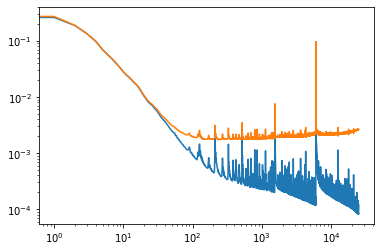

In [23]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

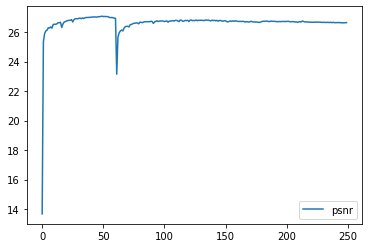

In [24]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

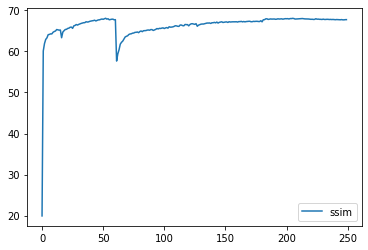

In [25]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

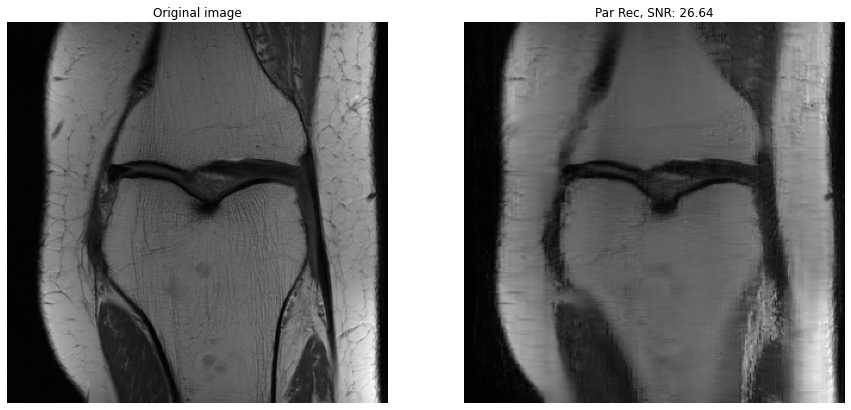

In [26]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()

## Downsampling factor = 4
num_channels: 256 <br>
insize: [10,5] <br> 
num_layers: 7 <br>
iter=25000, lr=0.005

In [19]:
par_out_chs = parnet( parni.type(dtype) ).data.cpu().numpy()[0]
par_out_imgs = channels2imgs(par_out_chs)
# least squares reconstruciton
lsimg = lsreconstruction(measurement)
orig = crop_center( root_sum_of_squares(var_to_np(lsimg)) , 320,320)

# deep decoder reconstruction
prec = crop_center(root_sum_of_squares(par_out_imgs),320,320)

ssim_const = ssim(orig, prec,data_range=orig.max())

psnr_const = psnr(orig,prec,np.max(orig))

real/img parts:  tensor(661.3981, device='cuda:1') tensor(592.8040, device='cuda:1')


In [20]:
psnr_const,ssim_const

(32.437570499272596, 0.8196950223371373)

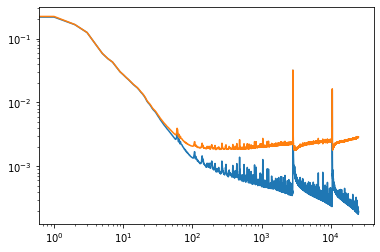

In [21]:
plt.loglog(par_mse_n)
plt.loglog(par_mse_t)
plt.show()

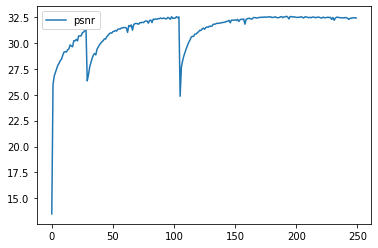

In [22]:
plt.plot(pover,label="psnr")
plt.legend()
plt.show()

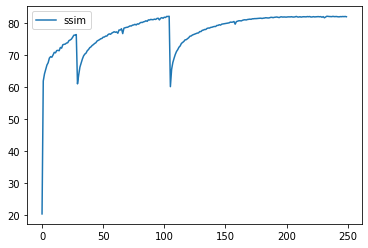

In [23]:
plt.plot(100*np.array(sover),label="ssim")
plt.legend()
plt.show()

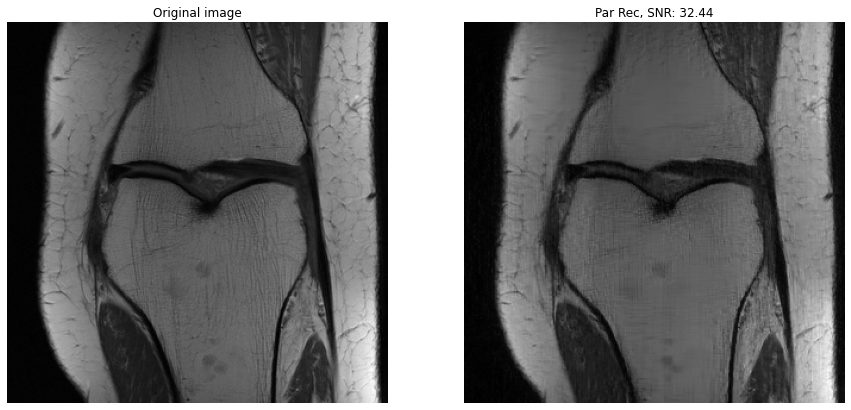

In [24]:
fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
ax1 = fig.add_subplot(121)
ax1.imshow(orig,cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

ax2 = fig.add_subplot(122)
ax2.imshow(prec,cmap='gray')
ax2.set_title( "Par Rec, SNR: %.2f" % psnr(orig,prec,np.max(orig) ) ) 
ax2.axis('off')    
    
plt.show()